In [1]:
import geopandas as gpd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import rioxarray as rxr
from scipy import stats, interpolate
from statsmodels.distributions.empirical_distribution import ECDF
import datetime as dt
from scipy.stats import norm
from copulas.multivariate import GaussianMultivariate, VineCopula
# from statsmodels.distributions.copula.api import (CopulaDistribution, GumbelCopula, IndependenceCopula, GaussianCopula)
import seaborn as sns

In [31]:
# Set dataset dir

dataset = '../../datasets/'
et = os.path.join(dataset, 'et/gha_lsa_et.nc')
precipitation = os.path.join(dataset, 'precipitation_chirps/precip_chirps_gha.nc')
tws = os.path.join(dataset, 'gha_tws.nc')
water_mask = os.path.join(dataset, 'water_mask/water_body.shp')

In [3]:
# Open and display

et_data = xr.open_dataset(et)['ET']

precipitation_data = xr.open_dataset(precipitation)['precipitation']

tws_data = xr.open_dataset(tws)['twsddk']

# Load water shapefile
water_shp = gpd.read_file(water_mask)


In [4]:
water_shp.explore()

In [5]:
et_data

<xarray.DataArray 'ET' (time: 252, lat: 697, lon: 592)>
[103981248 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 23.1 23.05 23.0 22.95 ... -11.55 -11.6 -11.65 -11.7
  * lon      (lon) float32 21.85 21.9 21.95 22.0 22.05 ... 51.25 51.3 51.35 51.4
  * time     (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-12-01
Attributes:
    long_name:     ET
    units:         mm
    grid_mapping:  crs

In [6]:
precipitation_data

<xarray.DataArray 'precipitation' (time: 250, y: 698, x: 591)>
[103129500 values with dtype=float32]
Coordinates:
    band     int64 ...
  * x        (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
  * y        (y) float64 23.12 23.07 23.02 22.97 ... -11.58 -11.63 -11.68 -11.73
  * time     (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_DATETIME:          2015:01:30 07:43:45
    TIFFTAG_DOCUMENTNAME:      /home/CHIRPS/monthly/v2.0/africa/chirps-v2.0.2...
    TIFFTAG_IMAGEDESCRIPTION:  IDL TIFF file
    TIFFTAG_RESOLUTIONUNIT:    2 (pixels/inch)
    TIFFTAG_SOFTWARE:          IDL 8.3, Exelis Visual Information Solutions, ...
    TIFFTAG_XRESOLUTION:       100
    TIFFTAG_YRESOLUTION:       100
    units:                     mm
    grid_mapping:              spatial_ref

In [32]:
tws_data = tws_data.sel(time=slice('2004-01-01', None))
tws_data

<xarray.DataArray 'twsddk' (lat: 34, lon: 30, time: 219)>
[223380 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:00:00
  * lat      (lat) float64 -11.0 -10.0 -9.0 -8.0 -7.0 ... 19.0 20.0 21.0 22.0
  * lon      (lon) float64 22.0 23.0 24.0 25.0 26.0 ... 47.0 48.0 49.0 50.0 51.0
Attributes:
    grid_mapping:  spatial_ref

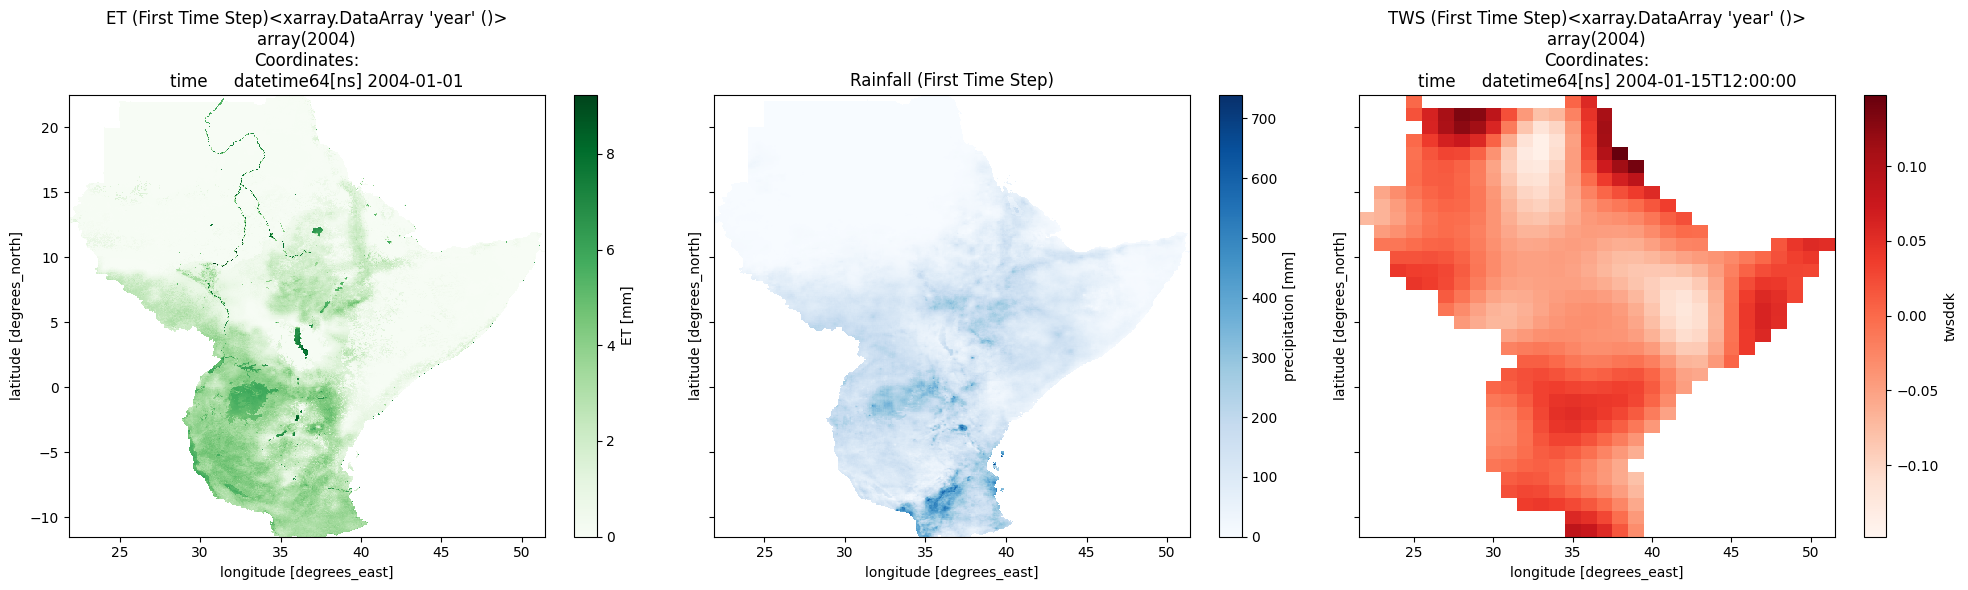

In [253]:
et1 = et_data.isel(time=0)
precip1 = precipitation_data.isel(time=0)
tws1 = tws_data.isel(time=0)

# Set up the figure and axes (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Plot ET
et1.plot(ax=axes[0], cmap="Greens", add_colorbar=True)
axes[0].set_title("ET (First Time Step){}".format(et1.time.dt.year))

# Plot Rainfall
precip1.plot(ax=axes[1], cmap="Blues", add_colorbar=True)
axes[1].set_title("Rainfall (First Time Step)")

# Plot TWS
tws1.plot(ax=axes[2], cmap="Reds", add_colorbar=True)
axes[2].set_title("TWS (First Time Step){}".format(tws1.time.dt.year))

plt.tight_layout()
plt.show()

In [254]:
# Variables at a location in GHA

lat = 5.34
lon = 45.34

et_poi = et_data.sel(lat=lat, lon=lon, method='nearest')
pre_poi = precipitation_data.sel(y=lat, x=lon, method='nearest')
tws_poi = tws_data.sel(lat=lat, lon=lon, method='nearest')

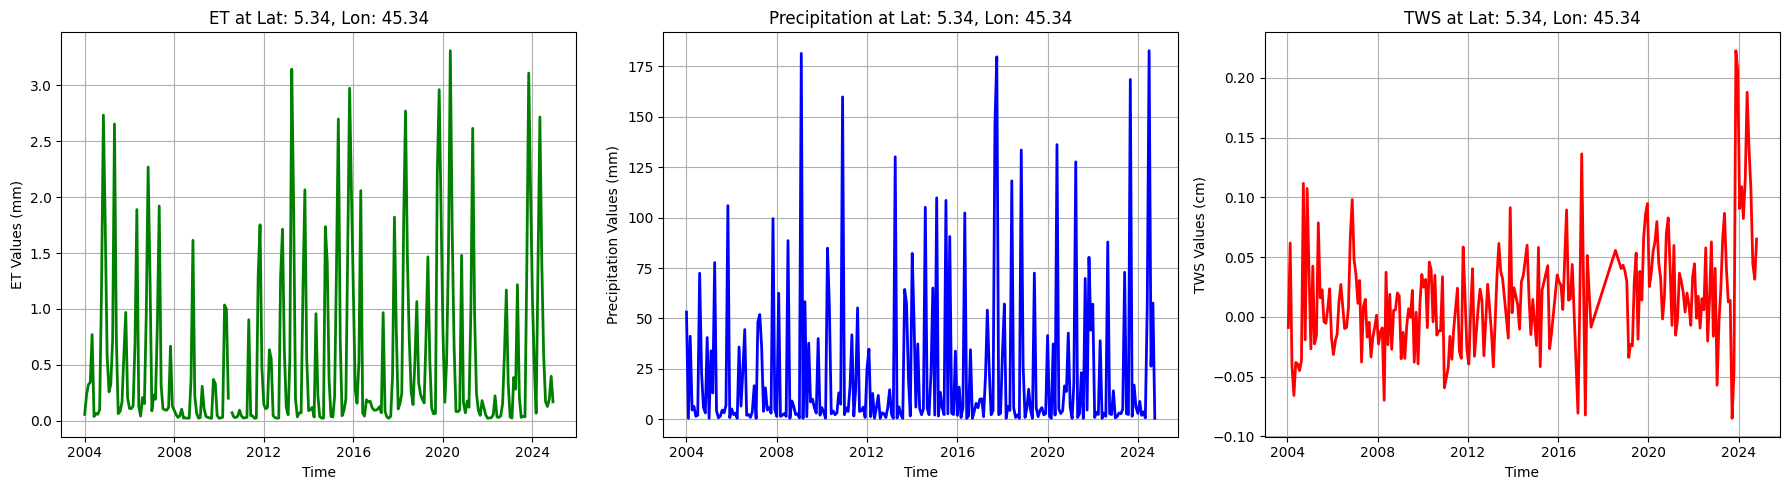

In [255]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
axes[0].plot(et_poi.time, et_poi.values, color='green', linewidth=2)
axes[0].set_title('ET at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('ET Values (mm)', fontsize=10)
axes[0].grid(True)

# Precipitation time series
axes[1].plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
axes[1].set_title('Precipitation at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[1].set_xlabel('Time', fontsize=10)
axes[1].set_ylabel('Precipitation Values (mm)', fontsize=10)
axes[1].grid(True)

# TWS time series
axes[2].plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
axes[2].set_title('TWS at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[2].set_xlabel('Time', fontsize=10)
axes[2].set_ylabel('TWS Values (cm)', fontsize=10)
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

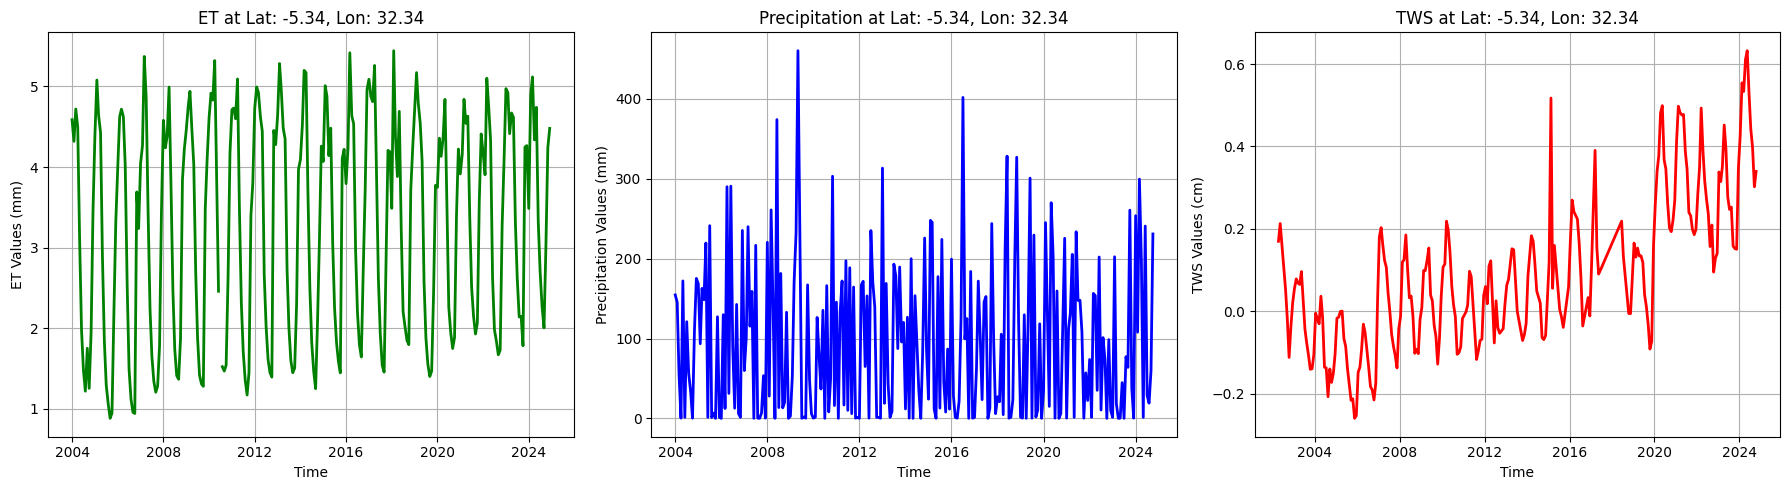

In [30]:
# Variables at a location in GHA

lat = -5.34
lon = 32.34

et_poi = et_data.sel(lat=lat, lon=lon, method='nearest')
pre_poi = precipitation_data.sel(y=lat, x=lon, method='nearest')
tws_poi = tws_data.sel(lat=lat, lon=lon, method='nearest')

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
axes[0].plot(et_poi.time, et_poi.values, color='green', linewidth=2)
axes[0].set_title('ET at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('ET Values (mm)', fontsize=10)
axes[0].grid(True)

# Precipitation time series
axes[1].plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
axes[1].set_title('Precipitation at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[1].set_xlabel('Time', fontsize=10)
axes[1].set_ylabel('Precipitation Values (mm)', fontsize=10)
axes[1].grid(True)

# TWS time series
axes[2].plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
axes[2].set_title('TWS at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[2].set_xlabel('Time', fontsize=10)
axes[2].set_ylabel('TWS Values (cm)', fontsize=10)
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

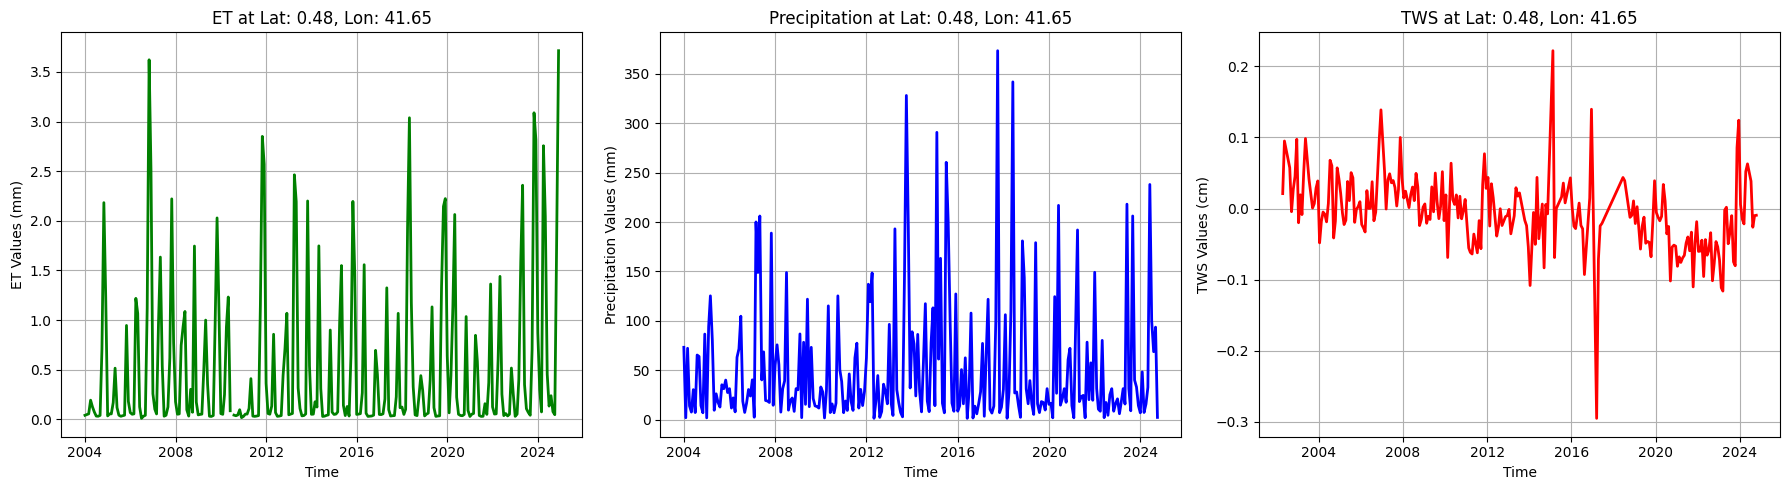

In [14]:
# Variables at a location in GHA

# Water body
lat = -1.15
lon = 32.87

lat = 3.81
lon = 36.04

# Land
# lat = 8.58
# lon = 31.56

lat = 0.48
lon = 41.65


et_poi_1 = et_data.sel(lat=lat, lon=lon, method='nearest')
pre_poi_1 = precipitation_data.sel(y=lat, x=lon, method='nearest')
tws_poi_1 = tws_data.sel(lat=lat, lon=lon, method='nearest')

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

# ET time series
axes[0].plot(et_poi_1.time, et_poi_1.values, color='green', linewidth=2)
axes[0].set_title('ET at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[0].set_xlabel('Time', fontsize=10)
axes[0].set_ylabel('ET Values (mm)', fontsize=10)
axes[0].grid(True)

# Precipitation time series
axes[1].plot(pre_poi_1.time, pre_poi_1.values, color='blue', linewidth=2)
axes[1].set_title('Precipitation at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[1].set_xlabel('Time', fontsize=10)
axes[1].set_ylabel('Precipitation Values (mm)', fontsize=10)
axes[1].grid(True)

# TWS time series
axes[2].plot(tws_poi_1.time, tws_poi_1.values, color='red', linewidth=2)
axes[2].set_title('TWS at Lat: {:.2f}, Lon: {:.2f}'.format(lat, lon), fontsize=12)
axes[2].set_xlabel('Time', fontsize=10)
axes[2].set_ylabel('TWS Values (cm)', fontsize=10)
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

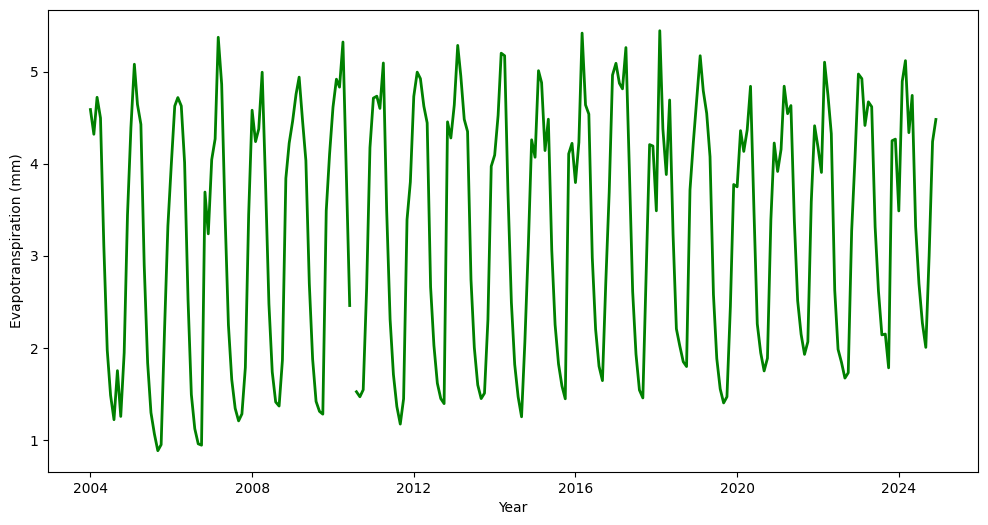

In [15]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plt.plot(et_poi.time, et_poi.values, color='green', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Evapotranspiration (mm)")
# plt.title("Time Series Plot")
plt.show()

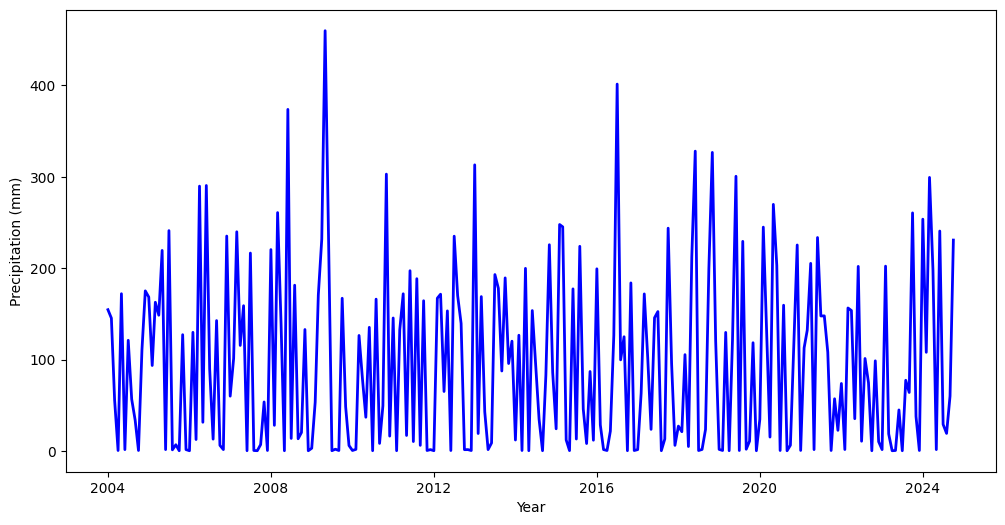

In [16]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plt.plot(pre_poi.time, pre_poi.values, color='blue', linewidth=2)
plt.xlabel("Year")
plt.ylabel("Precipitation (mm)")
# plt.title("Time Series Plot")
plt.show()


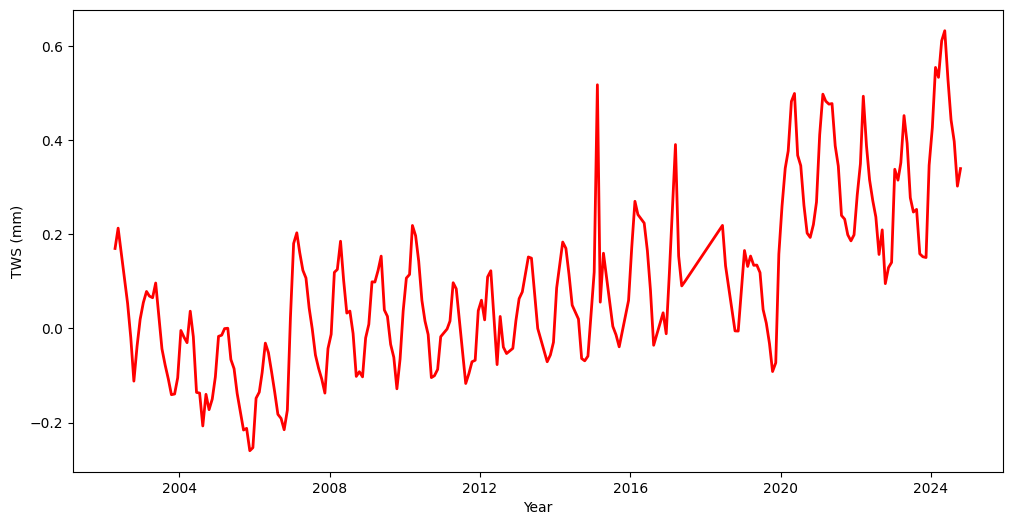

In [17]:
plt.figure(figsize=(12, 6))  # Adjust width and height as needed
plt.plot(tws_poi.time, tws_poi.values, color='red', linewidth=2)
plt.xlabel("Year")
plt.ylabel("TWS (mm)")
# plt.title("Time Series Plot")
plt.show()


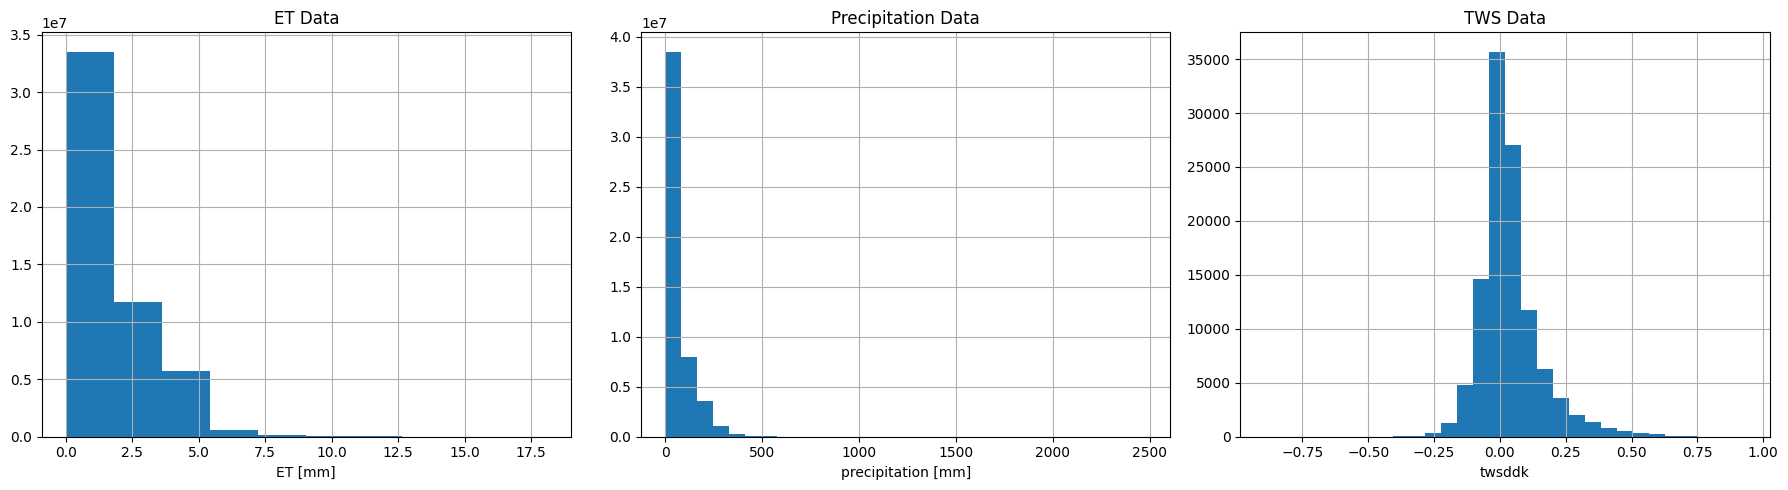

In [256]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

et_data.plot.hist(ax=axes[0], bins=10)
axes[0].grid(True)
axes[0].set_title('ET Data')

precipitation_data.plot.hist(ax=axes[1], bins=30)
axes[1].grid(True)
axes[1].set_title('Precipitation Data')

tws_data.plot.hist(ax=axes[2], bins=30)
axes[2].grid(True)
axes[2].set_title('TWS Data')

plt.tight_layout()
plt.show()

(array([ 47099., 124863., 177742., 138650., 129974., 178433., 225326.,
        257718., 321833., 377087., 425062., 472135., 543088., 576599.,
        627485., 649320., 689003., 687298., 677096., 646096., 621216.,
        598459., 585321., 569143., 564803., 557183., 565463., 579584.,
        608524., 621899., 610651., 576630., 533198., 481198., 443300.,
        401966., 367427., 331536., 303929., 268729., 238560., 201440.,
        174874., 148043., 127907., 108876.,  96390.,  84592.,  77505.,
         71011.,  67141.,  62540.,  59985.,  56754.,  55725.,  52993.,
         52739.,  50891.,  50812.,  49653.,  49363.,  48374.,  48120.,
         47185.,  47233.,  46297.,  45953.,  44950.,  45269.,  43950.,
         44419.,  43806.,  43623.,  42582.,  42546.,  41556.,  41445.,
         41340.,  41108.,  40753.,  40478.,  40022.,  39932.,  39413.,
         38980.,  38242.,  38678.,  37741.,  37777.,  37423.,  37640.,
         37012.,  36935.,  36307.,  36349.,  35868.,  36007.,  35202.,
      

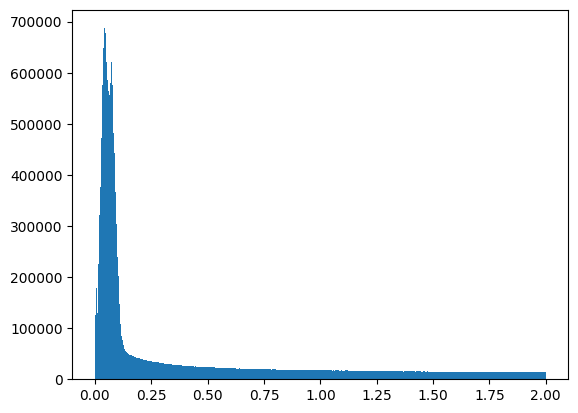

In [32]:
plt.hist(et_data.values[et_data.values < 2], bins=800)

#### Regriding datasets

In [8]:
# Interpolate to match the TWS grid
precip_resampled = precipitation_data.interp(y=tws_data.lat, x=tws_data.lon, method='nearest')
et_resampled = et_data.interp(lat=precipitation_data.lat, lon=tws_data.lon, method='nearest')

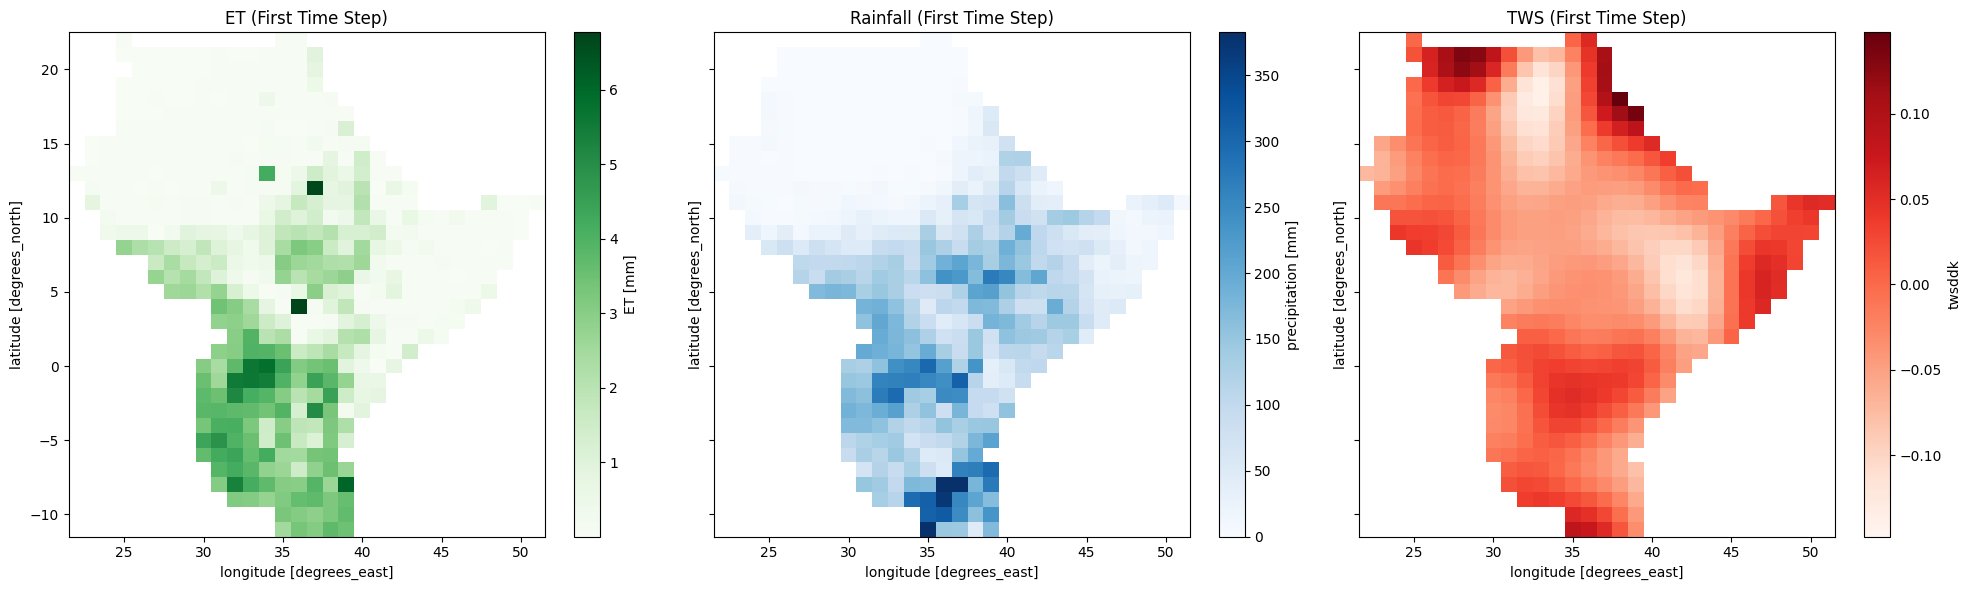

In [34]:
# Plot the regrided datasets

et2 = et_resampled.isel(time=0)
precip2 = precip_resampled.isel(time=0)
tws2 = tws_data.isel(time=0)

# Set up the figure and axes (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)


# Plot ET
et2.plot(ax=axes[0], cmap="Greens", add_colorbar=True)
axes[0].set_title("ET (First Time Step)")

# Plot Rainfall
precip2.plot(ax=axes[1], cmap="Blues", add_colorbar=True)
axes[1].set_title("Rainfall (First Time Step)")

# Plot TWS
tws2.plot(ax=axes[2], cmap="Reds", add_colorbar=True)
axes[2].set_title("TWS (First Time Step)")

plt.tight_layout()
plt.show()

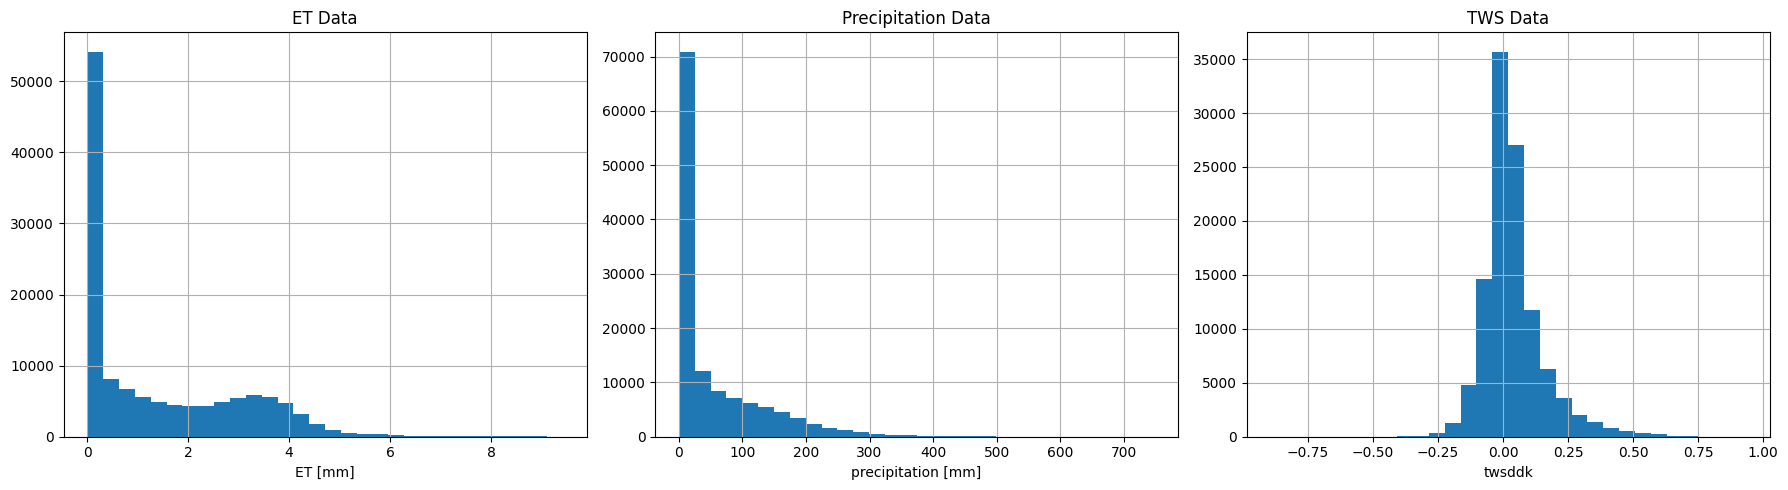

In [260]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

et_resampled.plot.hist(ax=axes[0], bins=30)
axes[0].grid(True)
axes[0].set_title('ET Data')

precip_resampled.plot.hist(ax=axes[1], bins=30)
axes[1].grid(True)
axes[1].set_title('Precipitation Data')

tws_data.plot.hist(ax=axes[2], bins=30)
axes[2].grid(True)
axes[2].set_title('TWS Data')

plt.tight_layout()
plt.show()

In [74]:
# Mask ET data
et_land = et_resampled.where(water_mask_xr == 0)  # ET over land
et_water = et_resampled.where(water_mask_xr == 1)  # ET over water

# Convert to NumPy for histogram plotting
et_land_values = et_land.values.flatten()
et_water_values = et_water.values.flatten()

# Remove NaN values
et_land_values = et_land_values[~np.isnan(et_land_values)]
et_water_values = et_water_values[~np.isnan(et_water_values)]


### Anomalies Calculation

#### Evapotranspitation

In [20]:
# Calculate monthly climatology (mean for each month over the years)
et_climatology = et_data.groupby("time.month").mean("time")

# Calculate anomalies
et_anomalies = et_data.groupby("time.month") - et_climatology

# Calculate monthly standard deviation over the years
et_std = et_data.groupby("time.month").std("time")

# Calculate standardized anomalies
et_standardized_anomalies = et_anomalies / et_std


In [21]:
et_standardized_anomalies

<xarray.DataArray 'ET' (time: 252, lat: 697, lon: 592, month: 12)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * lat      (lat) float32 23.1 23.05 23.0 22.95 ... -11.55 -11.6 -11.65 -11.7
  * lon      (lon) float32 21.85 21.9 21.95 22.0 22.05 ... 51.25 51.3 51.35 51.4
  * time     (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-12-01
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

#### Precipitation

In [22]:
# Calculate monthly climatology (mean for each month over the years)
precipitation_clim = precipitation_data.groupby("time.month").mean("time")

# Calculate anomalies
precipitation_anomalies = precipitation_data.groupby("time.month") - precipitation_clim

# Calculate the standard deviation for each month over the years
precipitation_std = precipitation_data.groupby("time.month").std("time")

# Calculate standardized anomalies
pre_standardized_anomalies = precipitation_anomalies / precipitation_std


In [23]:
pre_standardized_anomalies

<xarray.DataArray 'precipitation' (time: 250, y: 698, x: 591, month: 12)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
    band     (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * x        (x) float64 21.88 21.93 21.98 22.03 ... 51.23 51.28 51.33 51.38
  * y        (y) float64 23.12 23.07 23.02 22.97 ... -11.58 -11.63 -11.68 -11.73
  * time     (time) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

#### TWS

In [24]:
# Calculate monthly climatology (mean for each month over the years)
tws_clim = tws_data.groupby("time.month").mean("time")

# Calculate anomalies
tws_anomalies = tws_data.groupby("time.month") - tws_clim

# Calculate the standard deviation for each month over the years
tws_std = tws_data.groupby("time.month").std("time")

# Calculate standardized anomalies
tws_standardized_anomalies = tws_anomalies / tws_std


In [25]:
tws_standardized_anomalies

<xarray.DataArray 'twsddk' (lat: 34, lon: 30, time: 237, month: 12)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * time     (time) datetime64[ns] 2002-04-15T12:00:00 ... 2024-10-15T12:00:00
  * lat      (lat) float64 -11.0 -10.0 -9.0 -8.0 -7.0 ... 19.0 20.0 21.0 22.0
  * lon      (lon) float64 22.0 23.0 24.0 25.0 26.0 ... 47.0 48.0 49.0 50.0 51.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### Standardization with regridded data

In [35]:
# ET
et_climatology = et_resampled.groupby("time.month").mean("time")

et_anomalies = et_resampled.groupby("time.month") - et_climatology

et_std = et_resampled.groupby("time.month").std("time")

et_st_anomalies = et_anomalies.groupby("time.month") / et_std



In [36]:
# Preciptation
precipitation_clim = precip_resampled.groupby("time.month").mean("time")

precipitation_anomalies = precip_resampled.groupby("time.month") - precipitation_clim

precipitation_std = precip_resampled.groupby("time.month").std("time")

pre_st_anomalies = precipitation_anomalies.groupby("time.month") / precipitation_std


In [37]:
# TWS
tws_clim = tws_data.groupby("time.month").mean("time")

tws_anomalies = tws_data.groupby("time.month") - tws_clim

tws_std = tws_data.groupby("time.month").std("time")

tws_st_anomalies = tws_anomalies.groupby("time.month") / tws_std


In [50]:
et_st_anomalies.to_netcdf(os.path.join(dataset, 'et_standardized_anomaly.nc'))
pre_st_anomalies.to_netcdf(os.path.join(dataset, 'precip_standardized_anomaly.nc'))
tws_st_anomalies.to_netcdf(os.path.join(dataset, 'tws_standardized_anomaly.nc'))

## Marginal Distribution

#### Clean data and stack

In [41]:
# Remove NaNs from the standardised anomalies
et_clean = et_st_anomalies.stack(dims=['lon', 'lat', 'time'])

et_clean = et_clean[~np.isnan(et_clean)]
et_clean

<xarray.DataArray 'ET' (dims: 127257)>
array([ 1.4119531 ,  0.5897869 ,  0.37962255, ..., -0.43702904,
       -0.67395458, -0.51322579])
Coordinates:
    month    (dims) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * dims     (dims) object MultiIndex
  * lon      (dims) float64 22.0 22.0 22.0 22.0 22.0 ... 51.0 51.0 51.0 51.0
  * lat      (dims) float64 13.0 13.0 13.0 13.0 13.0 ... 11.0 11.0 11.0 11.0
  * time     (dims) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-12-01

In [38]:
# Stack all dimensions
precip_clean = pre_st_anomalies.stack(dims=['lon', 'lat', 'time'])

precip_clean = precip_clean[~np.isnan(precip_clean)]
precip_clean

<xarray.DataArray 'precipitation' (dims: 126000)>
array([-0.6829945 , -0.5721328 , -0.2218829 , ..., -0.17322612,
        0.71011627, -0.17979637], dtype=float32)
Coordinates:
    band     (dims) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    y        (dims) float64 13.0 13.0 13.0 13.0 13.0 ... 11.0 11.0 11.0 11.0
    x        (dims) float64 22.0 22.0 22.0 22.0 22.0 ... 51.0 51.0 51.0 51.0
    month    (dims) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 12 1 2 3 4 5 6 7 8 9 10
  * dims     (dims) object MultiIndex
  * lon      (dims) float64 22.0 22.0 22.0 22.0 22.0 ... 51.0 51.0 51.0 51.0
  * lat      (dims) float64 13.0 13.0 13.0 13.0 13.0 ... 11.0 11.0 11.0 11.0
  * time     (dims) datetime64[ns] 2004-01-01 2004-02-01 ... 2024-10-01

In [39]:
# Stack all dimensions
tws_clean = tws_st_anomalies.stack(dims=['lon', 'lat', 'time'])

tws_clean = tws_clean[~np.isnan(tws_clean)]
tws_clean

<xarray.DataArray 'twsddk' (dims: 111033)>
array([-1.27401966, -0.4312428 , -0.94214184, ...,  1.50595881,
        0.60692815,  0.8223124 ])
Coordinates:
    month    (dims) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 12 1 2 3 4 5 6 7 8 9 10
  * dims     (dims) object MultiIndex
  * lon      (dims) float64 22.0 22.0 22.0 22.0 22.0 ... 51.0 51.0 51.0 51.0
  * lat      (dims) float64 13.0 13.0 13.0 13.0 13.0 ... 11.0 11.0 11.0 11.0
  * time     (dims) datetime64[ns] 2004-01-15T12:00:00 ... 2024-10-15T12:00:00

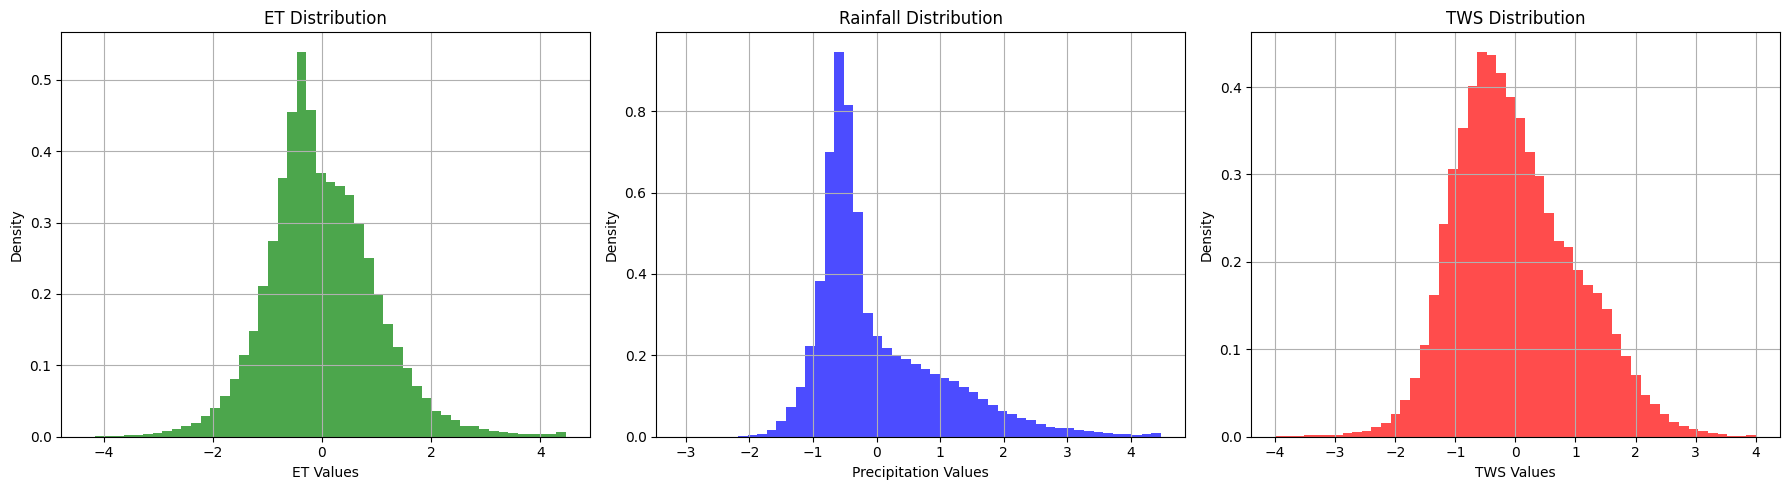

In [268]:
# Plot the histogram
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot ET Histogram
axes[0].hist(et_clean, bins=50, density=True, alpha=0.7, color='green')
axes[0].set_title("ET Distribution")
axes[0].set_xlabel("ET Values")
axes[0].set_ylabel("Density")
axes[0].grid(True)

# Plot Precipitation Histogram
axes[1].hist(precip_clean, bins=50, density=True, alpha=0.7, color='blue')
axes[1].set_title("Rainfall Distribution")
axes[1].set_xlabel("Precipitation Values")
axes[1].set_ylabel("Density")
axes[1].grid(True)

# Plot TWS Histogram
axes[2].hist(tws_clean, bins=50, density=True, alpha=0.7, color='red')
axes[2].set_title("TWS Distribution")
axes[2].set_xlabel("TWS Values")
axes[2].set_ylabel("Density")
axes[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


## Read the anomalies

In [12]:
et_clean = xr.open_dataset(os.path.join(dataset, 'et_standardized_anomaly.nc'))['ET']

precip_clean = xr.open_dataset(os.path.join(dataset, 'precip_standardized_anomaly.nc'))['precipitation']

tws_clean = xr.open_dataset(os.path.join(dataset, 'tws_standardized_anomaly.nc'))['twsddk']

(array([   99.,   683.,  3602., 18563., 48908., 35752., 14565.,  3589.,
         1004.,   492.]),
 array([-4.33346666, -3.45292688, -2.5723871 , -1.69184731, -0.81130753,
         0.06923226,  0.94977204,  1.83031183,  2.71085161,  3.59139139,
         4.47193118]),
 <BarContainer object of 10 artists>)

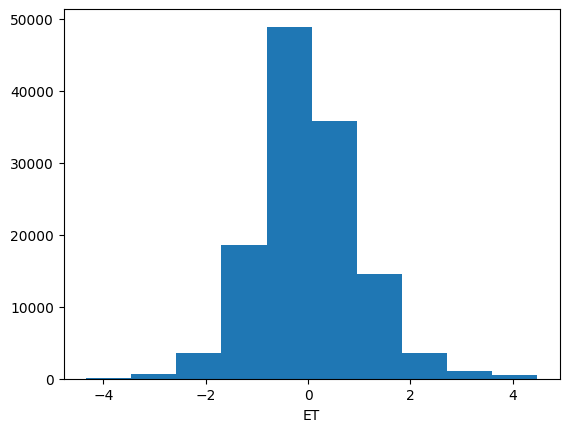

In [42]:
et_clean.plot.hist()

In [43]:
# Compute ECDF for ET
ecdf_et = ECDF(et_clean)

# Compute ECDF for Precipitation
ecdf_precip = ECDF(precip_clean)

# Compute ECDF for TWS
ecdf_twsa = ECDF(tws_clean)


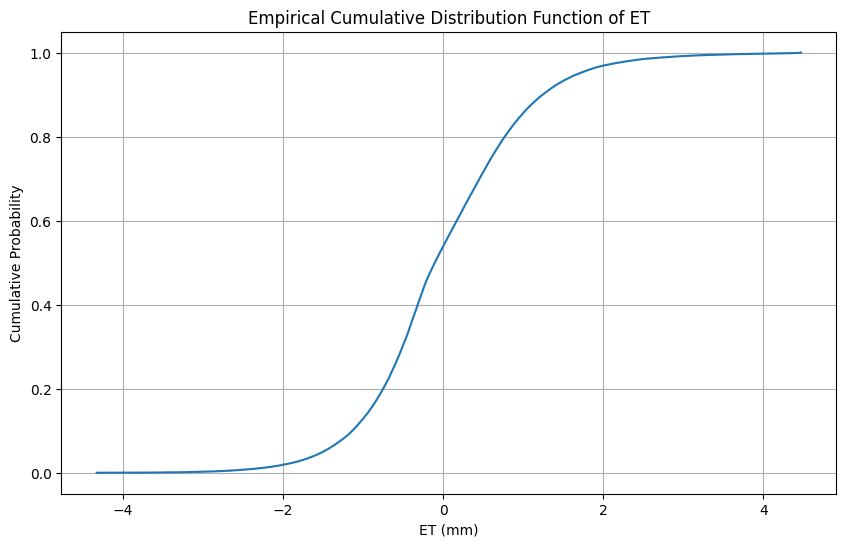

In [271]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_et.x, ecdf_et.y, where='post')
plt.xlabel('ET (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of ET')
plt.grid(True)
plt.show()

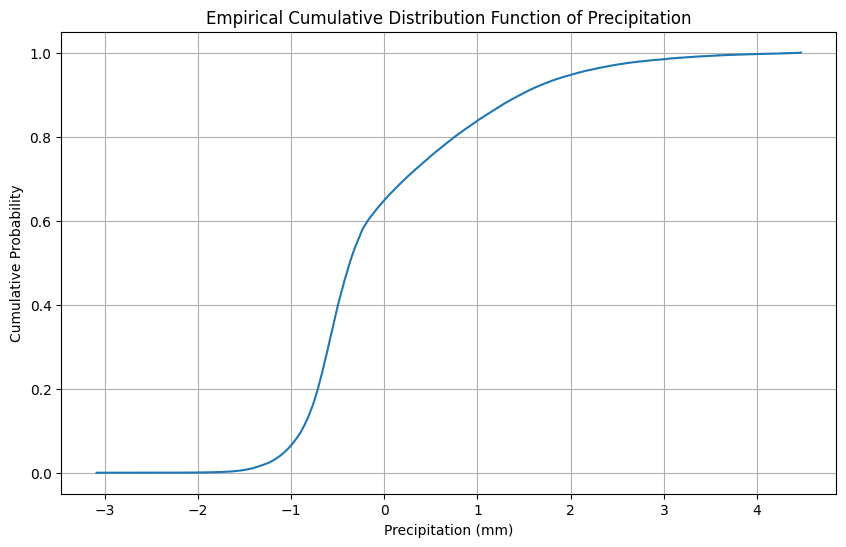

In [272]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_precip.x, ecdf_precip.y, where='post')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of Precipitation')
plt.grid(True)
plt.show()


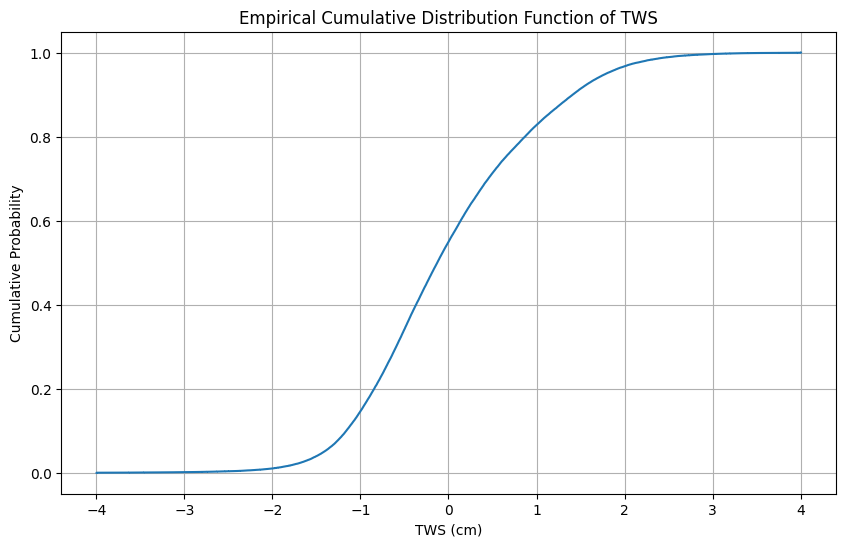

In [273]:
plt.figure(figsize=(10, 6))
plt.step(ecdf_twsa.x, ecdf_twsa.y, where='post')
plt.xlabel('TWS (cm)')
plt.ylabel('Cumulative Probability')
plt.title('Empirical Cumulative Distribution Function of TWS')
plt.grid(True)
plt.show()

#### Transform to uniform margin

In [44]:
# Transform TWSA data
uniform_twsa = ecdf_twsa(tws_clean)

# Transform Precip data
uniform_precip = ecdf_precip(precip_clean)

# Transform ET data
uniform_et = ecdf_et(et_clean)


#### Fit to Copula

In [48]:
# Using Copulae Module
from copulae import GaussianCopula, ClaytonCopula, FrankCopula, GumbelCopula, StudentCopula

In [46]:
# Select subset of the data
uniform_data = np.column_stack([uniform_et[:110000], uniform_precip[:110000], uniform_twsa[:110000]])

##### Archimidean Copulas

##### Elliptical Copulas

In [49]:
# Gaussian Copula
guassian_copula = GaussianCopula(dim=3)
guassian_copula.fit(uniform_data)

In [52]:
# Initialize copulas
copulas = {
    # Elliptical Copulas
    "Gaussian": GaussianCopula(dim=3), 
    "t-Student-t": StudentCopula(dim=3),
    
    # Archimidean Copulas
    "Frank": FrankCopula(dim=3), # Archime
    "Clayton": ClaytonCopula(dim=3),
    "Gumbel": GumbelCopula(dim=3)
}


In [ ]:

results = {}
for name, copula in copulas.items():
    try:
        copula.fit(uniform_data)
        
        # log-likelihood
        log_lik = copula.log_lik(uniform_data)
        
        if name == 't-Copula':
            n_params = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel':
            n_params = np.array(copula.params).size
        elif name == 'Gaussian':
            n_params = copula.params.size
        aic = -2 * log_lik + 2 * n_params
        bic = -2 * log_lik + np.log(uniform_data.shape[0]) * n_params
        
        # Calculate AIC and BIC
        # aic = -2 * log_lik + 2 * n_params
        # bic = -2 * log_lik + n_params * np.log(len(u_data))
        
        results[name] = {"Log-Likelihood": log_lik, "AIC": aic, "BIC": bic, "Parameters": copula.params}
        print(f"{name} Copula: Log-Likelihood={log_lik:.2f}, AIC={aic:.2f}, BIC={bic:.2f}")
    except Exception as e:
        print(f"Error fitting {name} Copula: {e}")

# Step 4: Select the best copula
best_copula_aic = min(results.items(), key=lambda x: x[1]["AIC"])
best_copula_bic = min(results.items(), key=lambda x: x[1]["BIC"])

print("\nBest Copula by AIC:")
print(f"Name: {best_copula_aic[0]}, AIC: {best_copula_aic[1]['AIC']:.2f}, Parameters: {best_copula_aic[1]['Parameters']}")
print("Best Copula by BIC:")
print(f"Name: {best_copula_bic[0]}, BIC: {best_copula_bic[1]['BIC']:.2f}, Parameters: {best_copula_bic[1]['Parameters']}")

# Optional: Store the best copula for further use
best_copula_name = best_copula_aic[0]  # or use BIC
best_copula = copulas[best_copula_name]

Gaussian Copula: Log-Likelihood=4.10, AIC=-2.20, BIC=26.63
Frank Copula: Log-Likelihood=2.83, AIC=0.35, BIC=29.17
1
Clayton Copula: Log-Likelihood=2.61, AIC=-3.23, BIC=6.38
1
Gumbel Copula: Log-Likelihood=-0.00, AIC=2.00, BIC=11.61

Best Copula by AIC:
Name: Clayton, AIC: -3.23, Parameters: 0.003977820390370242
Best Copula by BIC:
Name: Clayton, BIC: 6.38, Parameters: 0.003977820390370242


In [ ]:

results = []
for name, copula in copulas.items():
        log_likelihood = copula.log_lik(uniform_data)
        if name == 't-Copula':
            param_size = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel':
            param_size = np.array(copula.params).size
            print(param_size)
        elif name == 'Gaussian':
            param_size = copula.params.size
        aic = -2 * log_likelihood + 2 * param_size
        bic = -2 * log_likelihood + np.log(uniform_data.shape[0]) * param_size
        results.append({
            "Copula": name,
            "Log-Likelihood": log_likelihood,
            "AIC": aic,
            "BIC": bic,
            "Size": param_size
        })


# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

In [71]:
lower_tail = np.mean((u_data[:, 0] < 0.1) & (u_data[:, 1] < 0.1))
print(f"Observed Lower Tail Dependence: {lower_tail:.3f}")

Observed Lower Tail Dependence: 0.013


### Validate the Selected Copula


In [51]:
# Simulate new uniform marginals from the copula
simulated_data_gaussian = guassian_copula.random(1000)

In [53]:
simulated_data_gaussian

array([[0.44345467, 0.22936403, 0.89699113],
       [0.00806285, 0.35207936, 0.20551633],
       [0.11229731, 0.38413023, 0.82657997],
       ...,
       [0.44856415, 0.1380518 , 0.99545702],
       [0.90181554, 0.6073203 , 0.41077729],
       [0.89925841, 0.74643074, 0.99365719]])

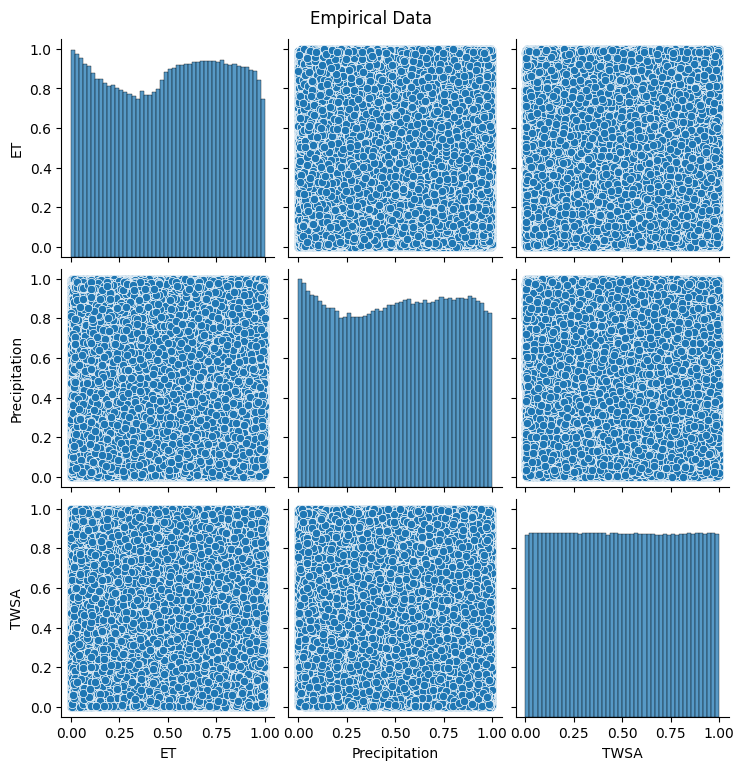

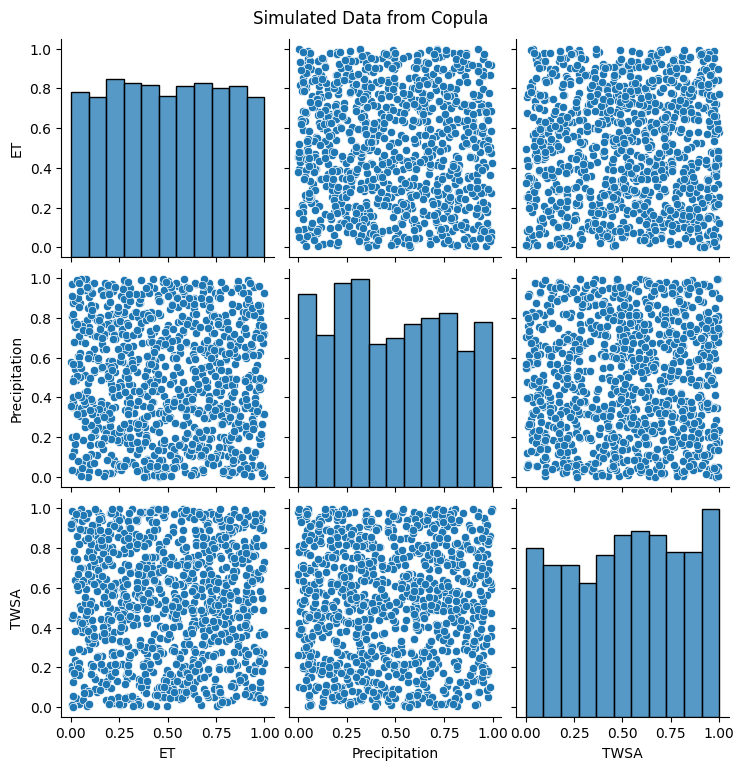

In [55]:
df_empirical = pd.DataFrame(uniform_data, columns=["ET", "Precipitation", "TWSA"])
df_synthetic = pd.DataFrame(simulated_data_gaussian, columns=["ET", "Precipitation", "TWSA"])

# Create a pairplot for empirical data
sns.pairplot(df_empirical)
plt.suptitle("Empirical Data", y=1.02)
plt.show()

# Create a pairplot for synthetic data from the copula
sns.pairplot(df_synthetic)
plt.suptitle("Simulated Data from Copula", y=1.02)
plt.show()


Observed Tau (ET-Precip): -0.013
Simulated Tau (ET-Precip): -0.035


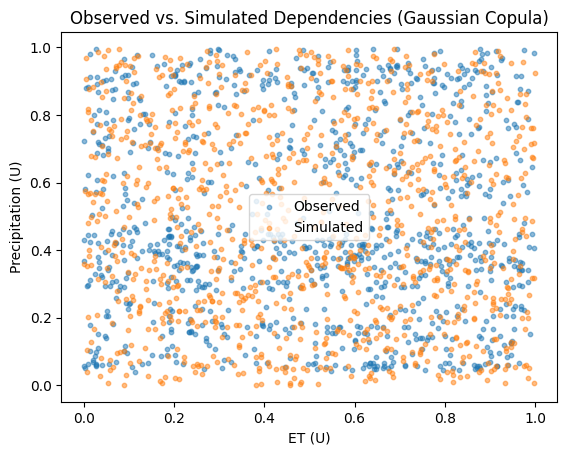

In [81]:
from scipy.stats import kendalltau

# Assuming u_data is your observed uniform margins from earlier
# u_data shape: (n_samples, 3) for ET, precip, TWS

# Generate simulated samples
# simulated_data_gaussian = gaussian_copula.random(1000)  # Shape: (1000, 3)

# Compare Kendall’s tau (dependency measure)
tau_obs_et_precip = kendalltau(uniform_data[:, 0][:1000], uniform_data[:, 1][:1000])[0]
tau_sim_et_precip = kendalltau(simulated_data_gaussian[:, 0], simulated_data_gaussian[:, 1])[0]
print(f"Observed Tau (ET-Precip): {tau_obs_et_precip:.3f}")
print(f"Simulated Tau (ET-Precip): {tau_sim_et_precip:.3f}")

# Visualize observed vs. simulated
plt.scatter(uniform_data[:, 0][:1000], uniform_data[:, 1][:1000], alpha=0.5, label="Observed", s=10)
plt.scatter(simulated_data_gaussian[:, 0], simulated_data_gaussian[:, 1], alpha=0.5, label="Simulated", s=10)
plt.xlabel("ET (U)")
plt.ylabel("Precipitation (U)")
plt.legend()
plt.title("Observed vs. Simulated Dependencies (Gaussian Copula)")
plt.show()

In [83]:
(uniform_data)

array([[0.92326552, 0.22411111, 0.07342862],
       [0.7462615 , 0.3274127 , 0.3728261 ],
       [0.67441477, 0.58372222, 0.16553637],
       ...,
       [0.29926055, 0.30216667, 0.21297272],
       [0.51014875, 0.89389683, 0.55275459],
       [0.6130429 , 0.05560317, 0.6618843 ]])

In [60]:
# Compute log-likelihood of the fitted copula
log_likelihood = guassian_copula.log_lik(uniform_data)
print(f"Log-Likelihood: {log_likelihood}")

# Compute AIC & BIC (lower values indicate better fit)
num_params = guassian_copula.params.size  # Number of parameters in copula
aic = -2 * log_likelihood + 2 * num_params
bic = -2 * log_likelihood + np.log(111000) * num_params

print(f"AIC: {aic}, BIC: {bic}")


Log-Likelihood: 4.098253271287421
AIC: -2.1965065425748413, BIC: 26.655349898308575


In [63]:
from scipy.stats import norm

# Convert uniform samples back to real-world values
et_simulated = ecdf_et(simulated_data_gaussian[:, 0])
precip_simulated = ecdf_precip(simulated_data_gaussian[:, 1])
tws_simulated = ecdf_twsa(simulated_data_gaussian[:, 2])


In [64]:
# Example: Simple average-based CDI
cdi = (et_simulated + precip_simulated + tws_simulated) / 3

# Normalize CDI to standard scores
cdi_standardized = (cdi - np.mean(cdi)) / np.std(cdi)


In [65]:
cdi_standardized

array([ 2.67563396e-01, -2.04009892e+00, -4.77215886e-01, -4.63243288e-01,
       -7.76227589e-01,  2.26707884e-01, -3.25253528e-01, -2.90763416e-01,
       -1.06037567e+00, -5.19830116e-01, -2.59348685e-01,  1.79626244e+00,
       -6.81250562e-01, -2.12394452e+00, -1.30644398e+00,  1.60808298e+00,
       -2.78471632e-01, -2.11141965e+00,  2.59146888e-01,  4.20480982e-01,
       -8.19434033e-01,  5.53635618e-01, -5.59122261e-01, -2.13128262e-01,
        1.14250879e+00,  1.48550740e+00, -1.28518423e+00, -1.89766647e+00,
        1.38702445e+00,  9.72512724e-01,  5.92271443e-01, -1.64059565e+00,
       -4.72980947e-01,  9.21572857e-01,  3.79551116e-01, -5.29567588e-01,
       -1.93389173e+00, -7.72158762e-01,  4.30336230e-01, -3.63812487e-01,
        3.91606685e-01,  1.30684512e+00, -5.16156976e-01,  1.28334992e+00,
       -9.39331789e-01,  2.10705102e+00,  6.38363898e-01,  1.49070799e+00,
        6.86170191e-02, -1.22563802e+00,  7.84777654e-02,  7.06894662e-01,
       -2.05127505e+00, -

In [67]:
cdi_standardized = cdi_standardized[:len(et_data['time'])]


In [71]:
cdi_standardized

array([ 2.67563396e-01, -2.04009892e+00, -4.77215886e-01, -4.63243288e-01,
       -7.76227589e-01,  2.26707884e-01, -3.25253528e-01, -2.90763416e-01,
       -1.06037567e+00, -5.19830116e-01, -2.59348685e-01,  1.79626244e+00,
       -6.81250562e-01, -2.12394452e+00, -1.30644398e+00,  1.60808298e+00,
       -2.78471632e-01, -2.11141965e+00,  2.59146888e-01,  4.20480982e-01,
       -8.19434033e-01,  5.53635618e-01, -5.59122261e-01, -2.13128262e-01,
        1.14250879e+00,  1.48550740e+00, -1.28518423e+00, -1.89766647e+00,
        1.38702445e+00,  9.72512724e-01,  5.92271443e-01, -1.64059565e+00,
       -4.72980947e-01,  9.21572857e-01,  3.79551116e-01, -5.29567588e-01,
       -1.93389173e+00, -7.72158762e-01,  4.30336230e-01, -3.63812487e-01,
        3.91606685e-01,  1.30684512e+00, -5.16156976e-01,  1.28334992e+00,
       -9.39331789e-01,  2.10705102e+00,  6.38363898e-01,  1.49070799e+00,
        6.86170191e-02, -1.22563802e+00,  7.84777654e-02,  7.06894662e-01,
       -2.05127505e+00, -

In [69]:
et_data = et_resampled.sel(time=cdi_standardized.time)


AttributeError: 'numpy.ndarray' object has no attribute 'time'

ValueError: x and y must have same first dimension, but have shapes (252,) and (1000,)

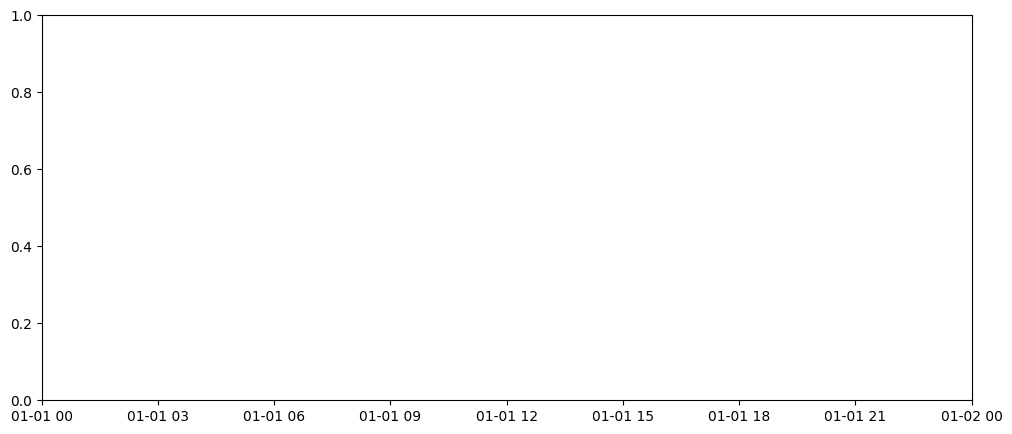

In [66]:
plt.figure(figsize=(12, 5))
plt.plot(et_data['time'], cdi_standardized, label="Copula-based Drought Index (CDI)", color='b')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Time")
plt.ylabel("CDI (Standardized)")
plt.title("Copula-based Drought Index Over Time")
plt.legend()
plt.show()


In [ ]:
# Calculating probabilities for specific scenarios and checking if they make sense.



In [57]:
# Define thresholds
a = np.quantile(et_clean, 0.1)  # 90th percentile for ET
b = np.quantile(precip_clean, 0.9)  # 90th percentile for Precipitation
c = np.quantile(tws_clean, 0.9)  # 90th percentile for TWSA

# Transform thresholds to uniform scale
u_a = ecdf_et(a)
u_b = ecdf_precip(b)
u_c = ecdf_twsa(c)

# Compute joint probability using the copula
joint_probability = guassian_copula.cdf([u_a, u_b, u_c])
print(f"Joint probability: {joint_probability}")

Joint probability: 0.08109321354922804


In [367]:
# Define thresholds
x = 50  # ET threshold
y = 100  # Precipitation threshold
z = -50  # TWS threshold

# Transform thresholds to uniform scale
u_x = ecdf_et(x)
u_y = ecdf_precip(y)
u_z = ecdf_twsa(z)

# Calculate joint probability
prob = copula.cdf([u_x, u_y, u_z])
print(f"Probability: {prob}")

Probability: 0.0


In [366]:
# Define thresholds
x = 2  # ET threshold
y = 1  # Precipitation threshold
z = 3  # TWS threshold

# Transform thresholds to uniform scale
u_x = 1 - ecdf_et(x)  # ET > x
u_y = ecdf_precip(y)  # Precipitation < y
u_z = 1 - ecdf_twsa(z)  # TWS > z

# Calculate joint probability
prob = copula.cdf([u_x, u_y, u_z])
print(f"Probability: {prob}")

Probability: 8.610569886367593e-05


### Goodness of fit 

In [313]:
from scipy.stats import kstest

def goodness_of_fit(copula, data):
    
    theoretical_cdf = copula.random(len(data))
    # Perform KS test
    ks_stat, p_value = kstest(data.flatten(), theoretical_cdf.flatten())
    return ks_stat, p_value

# Evaluate each copula
results = {}
for name, copula in copulas.items():
    ks_stat, p_value = goodness_of_fit(copula, uniform_data)
    results[name] = {'KS Statistic': ks_stat, 'p-value': p_value}

# Print results
for name, result in results.items():
    print(f"{name}: KS Statistic = {result['KS Statistic']}, p-value = {result['p-value']}")

Gaussian: KS Statistic = 0.02044666666666667, p-value = 1.1430997655077774e-27
t-Copula: KS Statistic = 0.01923999999999998, p-value = 1.5088038275012942e-24
Gumbel: KS Statistic = 0.019993333333333363, p-value = 1.7893862380351054e-26
Clayton: KS Statistic = 0.020893333333333375, p-value = 7.158625337067697e-29


#####  Test the copulas

In [314]:
# Compute log-likelihood, AIC, and BIC for each copula

results = []
for name, copula in copulas.items():
        log_likelihood = copula.log_lik(uniform_data)
        if name == 't-Copula':
            param_size = copula.params[1].size
        elif name == 'Clayton' or name == 'Gumbel':
            param_size = np.array(copula.params).size
            print(param_size)
        elif name == 'Gaussian':
            param_size = copula.params.size
        aic = -2 * log_likelihood + 2 * param_size
        bic = -2 * log_likelihood + np.log(uniform_data.shape[0]) * param_size
        results.append({
            "Copula": name,
            "Log-Likelihood": log_likelihood,
            "AIC": aic,
            "BIC": bic,
            "Size": param_size
        })


# Display results
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

1
1
     Copula  Log-Likelihood       AIC        BIC  Size
0  Gaussian        5.771486 -5.542971  20.916363     3
1  t-Copula        1.240248  3.519504  29.978839     3
2    Gumbel       -0.000144  2.000289  10.820067     1
3   Clayton        1.532401 -1.064802   7.754976     1


In [340]:
# Example AIC and BIC values for different copulas
copulas = {
    "Gaussian": {"AIC": 120.5, "BIC": 130.2},
    "Student-t": {"AIC": 115.3, "BIC": 126.8},
    "Clayton": {"AIC": 118.7, "BIC": 125.4},
    "Gumbel": {"AIC": 117.9, "BIC": 124.6},
    "Frank": {"AIC": 119.1, "BIC": 125.8},
}

# Find the best copula based on AIC
best_aic_copula = min(copulas, key=lambda x: copulas[x]["AIC"])
print(f"Best copula (AIC): {best_aic_copula}")

# Find the best copula based on BIC
best_bic_copula = min(copulas, key=lambda x: copulas[x]["BIC"])
print(f"Best copula (BIC): {best_bic_copula}")

### Create the drought Index

In [ ]:
# Initialize drought index array
drought_index = xr.DataArray(
    np.full((len(tws_st_anomalies.time), len(tws_st_anomalies.lat), len(tws_st_anomalies.lon)), np.nan),
    coords={"time": et_st_anomalies[:219].time, "lat": tws_st_anomalies.lat, "lon": tws_st_anomalies.lon},
    dims=["time", "lat", "lon"]
)

# Compute joint CDF for each grid point using the global copula
for lat in tws_st_anomalies.lat.values:
    for lon in tws_st_anomalies.lon.values:
        data = np.vstack([et_st_anomalies[:219].sel(lat=lat, lon=lon).values,
                         pre_st_anomalies[:219].sel(lat=lat, lon=lon).values,
                         tws_st_anomalies[:200].sel(lat=lat, lon=lon).values]).T
        valid_mask = ~np.isnan(data).any()
        if valid_mask.sum() == 0:
            print(f"No valid data at lat={lat}, lon={lon}")
            continue
        data_clean = data[valid_mask]
        u_data_local = np.vstack([ECDF(data_clean[:, k])(data_clean[:, k]) for k in range(3)]).T
        
        # Debug: Check inputs and copula output
        print(f"Lat={lat}, Lon={lon}, Valid points={valid_mask.sum()}")
        print(f"u_data_local sample: {u_data_local[:5]}")
        joint_cdf = best_copula.cdf(u_data_local)
        print(f"Joint CDF sample: {joint_cdf[:5]}")
        
        # Assign directly using array indexing
        drought_index.values[valid_mask, i, j] = joint_cdf



In [ ]:
drought_index.values

drought_index after computation:
nan nan
Any non-NaN values? False
drought_index_standardized:
3.090232306167813 3.090232306167813


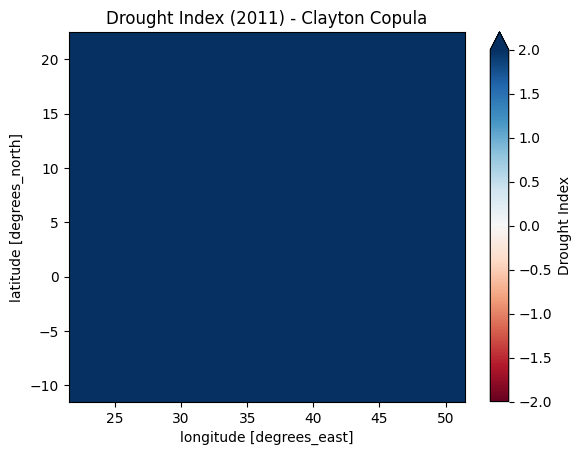

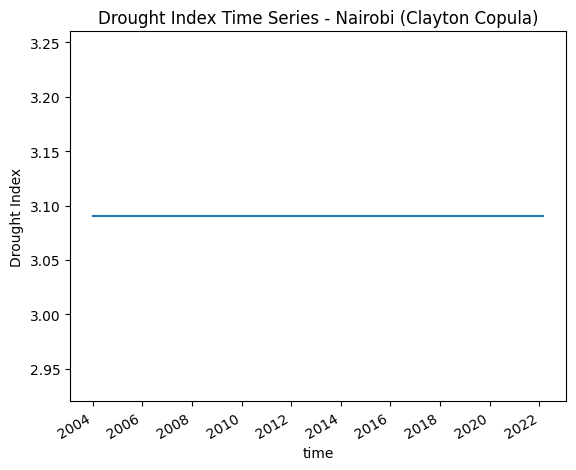

In [146]:
# Debug: Check drought_index
print("drought_index after computation:")
print(drought_index.min().item(), drought_index.max().item())
print("Any non-NaN values?", drought_index.notnull().any().item())

# Step 4: Standardize the drought index
drought_index = drought_index.where(drought_index > 0, 0.001).where(drought_index < 1, 0.999)  # Clip 0/1
drought_index_standardized = xr.apply_ufunc(norm.ppf, drought_index, keep_attrs=True).rename("Drought Index")

# Debug: Check standardized index
print("drought_index_standardized:")
print(drought_index_standardized.min().item(), drought_index_standardized.max().item())

# Step 5: Visualize
drought_index_standardized.sel(time=slice("2011-01-01", "2011-12-31")).mean(dim="time").plot(
    robust=True, cmap="RdBu", vmin=-2, vmax=2
)
plt.title(f"Drought Index (2011) - {best_copula_name} Copula")
plt.show()

drought_index_standardized.sel(lat=-1.3, lon=36.9, method="nearest").plot()
plt.title(f"Drought Index Time Series - Nairobi ({best_copula_name} Copula)")
plt.show()

In [414]:
# Transform back to the original scales using the inverse ECDFs
student_simulated_et = np.quantile(et_clean, simulated_uniform_student[:, 0])
student_simulated_precip = np.quantile(precip_clean, simulated_uniform_student[:, 1])
student_simulated_twsa = np.quantile(tws_clean, simulated_uniform_student[:, 2])

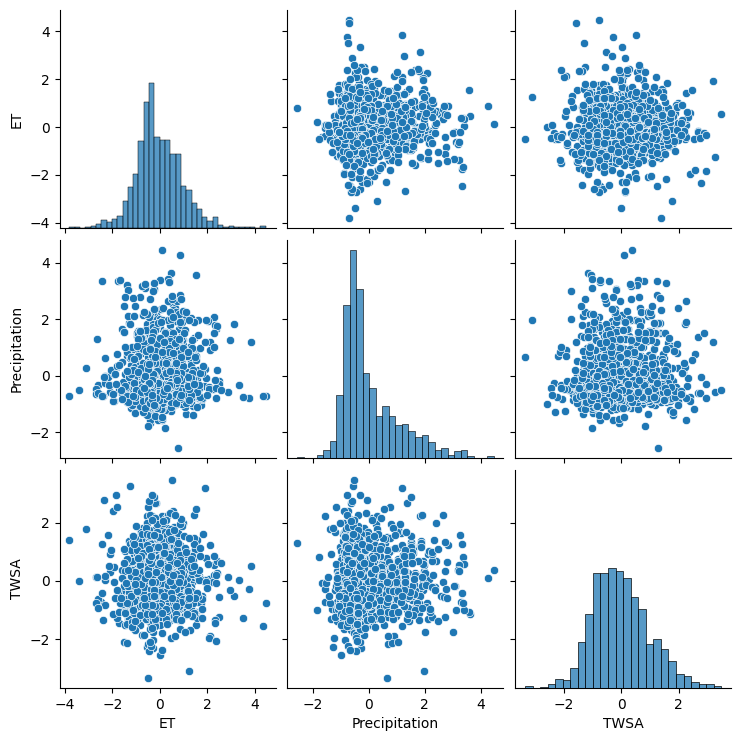

In [435]:
# Plot the simulated data
g = sns.pairplot(pd.DataFrame({
    'ET': gaussian_simulated_et,
    'Precipitation': gaussian_simulated_precip,
    'TWSA': gaussian_simulated_twsa
}))

plt.show()

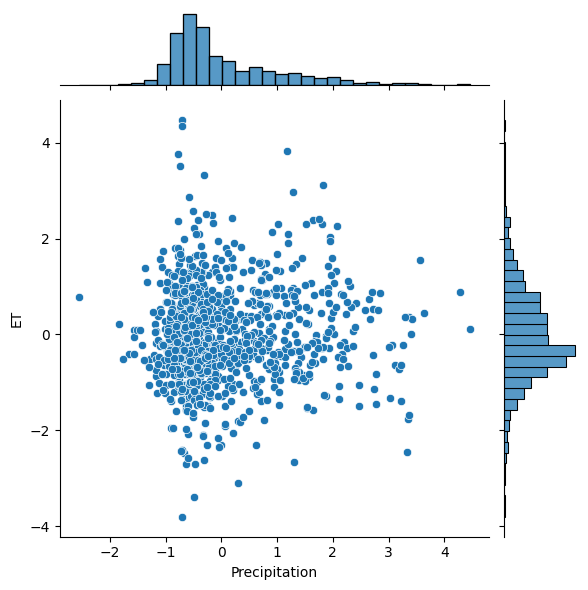

In [483]:
sns.jointplot(data=pd.DataFrame({
    'ET': gaussian_simulated_et,
    'Precipitation': gaussian_simulated_precip,
    'TWSA': gaussian_simulated_twsa
}), x='Precipitation', y='ET')

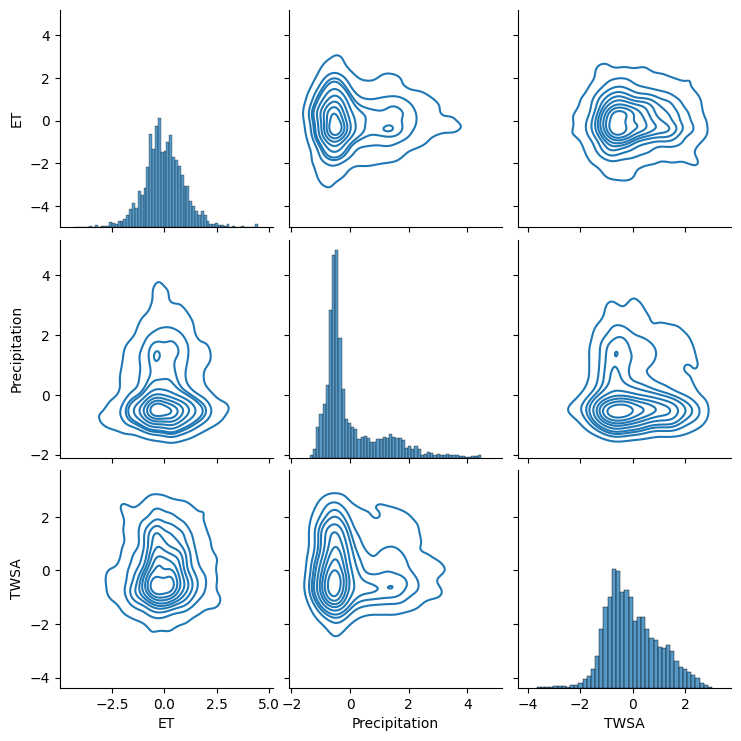

In [472]:
df = pd.DataFrame({
    "ET": et_clean[:5000],
    "Precipitation": precip_clean[:5000],
    "TWSA": tws_clean[:5000]
})

# Pairplot with Kernel Density Estimation (KDE) contours
sns.pairplot(df, diag_kind="hist", kind='kde')
plt.show()

In [318]:
# Compute the joint CDF using the fitted copula model
joint_cdf = guassian_copula.cdf(uniform_data)

# Display some of the joint probabilities
print("Joint CDF Values:", joint_cdf[:10])


Joint CDF Values: [0.01533338 0.09175629 0.06599814 0.08609613 0.00408029 0.07091126
 0.01183258 0.00753298 0.00021927 0.0216105 ]


In [341]:
marginals = [stats.gamma(2), stats.norm]
joint_dist = CopulaDistribution(copula=GaussianCopula(), marginals=marginals)
sample = joint_dist.rvs(1000, random_state=20210801)
h = sns.jointplot(x=sample[:, 0], y=sample[:, 1], kind="scatter")
_ = h.set_axis_labels("X1", "X2", fontsize=16)


AttributeError: 'GaussianCopula' object has no attribute 'rvs'

In [392]:
from copulas.datasets import sample_trivariate_xyz

data = sample_trivariate_xyz()

data.head()

x             y         z
0  9.004177e-05  2.883992e-06  0.638689
1  8.819273e-01  2.911979e-07  1.058121
2  5.003865e-01  4.886504e-04  0.372506
3  1.838544e-12  5.392802e-02  0.687370
4  1.627915e-01  1.634269e-08 -0.881068

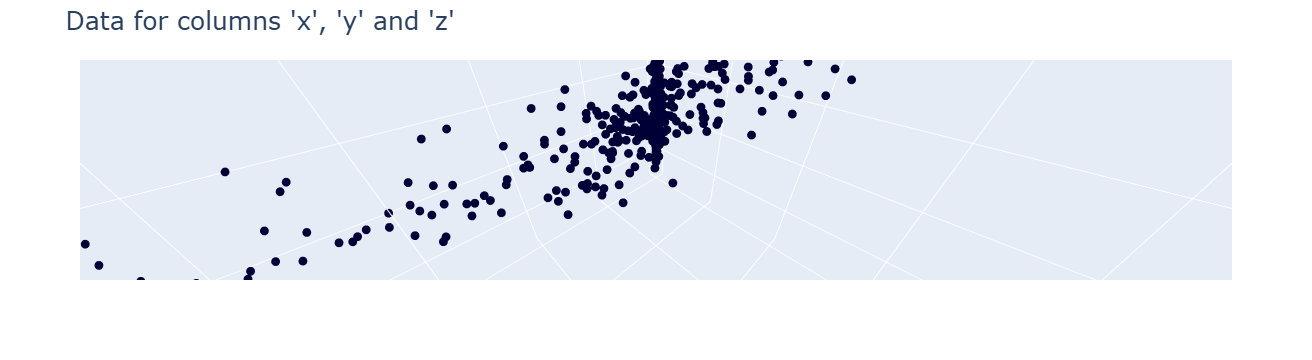

In [393]:
from copulas.visualization import scatter_3d

scatter_3d(data)